In [ ]:
# 
import os
import cv2 		
import matplotlib.pyplot as plt
import random
import numpy as np
import numpy
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.datasets import cifar10
from keras.layers import Add, Dense, Activation, BatchNormalization, Conv2D
from keras.layers import Flatten
from keras.layers.convolutional import MaxPooling2D
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow_datasets as tfds
import tensorflow as tf
from keras.utils import np_utils
from keras.initializers import glorot_uniform
%matplotlib inline

In [ ]:
model_type = 'vgg16'

In [ ]:
model_home_dir = os.path.join(os.getcwd(), 'CNN_TASK_ODED',"model_type")
print(model_home_dir)
if not os.path.isdir(model_home_dir):
    print('Inside mkdir')
    os.makedirs(model_home_dir)

/content/CNN_TASK_ODED/model_type
Inside mkdir


In [ ]:
#Defining Variables

#Data set information
DATASET = 'fruit360'
CATEGORIES = ['Apple Braeburn','Apple Crimson Snow','Apple Golden 1','Apple Golden 2',
 'Apple Golden 3','Apple Granny Smith','Apple Pink Lady','Apple Red 1',
 'Apple Red 2','Apple Red 3','Apple Red Delicious','Apple Red Yellow 1'
 ,'Apple Red Yellow 2','Pear','Pear 2','Pear Abate','Pear Forelle','Pear Kaiser'
 ,'Pear Monster','Pear Red','Pear Stone','Pear Williams']
class_name = ["Apple","Pear"] 
num_classes = 2
input_shape=(100, 100, 1)
img_size = 100
epochs = 200
lrate = 0.01
decay = lrate/epochs
batch_size = 32


validate_dir = os.path.join("data","test")
train_dir = os.path.join("data","train")

# Prepare model model saving directory.
save_dir = os.path.join(model_home_dir, 'saved_models')

model_name = DATASET+'_'+'%s_model.{epoch:03d}.h5' % model_type

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)
print("Model Type: ",model_type)
print("Model File: ",filepath)

Model Type:  vgg16
Model File:  /content/CNN_TASK_ODED/model_type/saved_models/fruit360_vgg16_model.{epoch:03d}.h5


In [ ]:
!git clone https://github.com/Horea94/Fruit-Images-Dataset.git

!ls

base_dir = 'Fruit-Images-Dataset/'

!ls Fruit-Images-Dataset/

Cloning into 'Fruit-Images-Dataset'...
remote: Enumerating objects: 385858, done.
remote: Counting objects: 100% (8693/8693), done.
remote: Compressing objects: 100% (8659/8659), done.
remote: Total 385858 (delta 37), reused 8688 (delta 34), pack-reused 377165
Receiving objects: 100% (385858/385858), 2.10 GiB | 26.47 MiB/s, done.
Resolving deltas: 100% (1197/1197), done.
Checking out files: 100% (90503/90503), done.
CNN_TASK_ODED  Fruit-Images-Dataset  sample_data
LICENSE  papers  readme.md  src  Test  test-multiple_fruits  Training


In [ ]:
# Read training set
train_images = []
train_dir = os.path.join(base_dir, 'Training/')										              # set the training directory in the path

for category in CATEGORIES:															                        # iterate to each category
    path = os.path.join(train_dir, category)
    class_num = CATEGORIES.index(category)
    if class_num <= 12:
      class_num = 0
    else:
      class_num = 1
    for image in os.listdir(path):													                    # iterate to each image in the category
        if(image.endswith('jpg') and not image.startswith('.')):
            img_array = cv2.imread(os.path.join(path,image),                    # read the image
                              cv2.IMREAD_GRAYSCALE)	
            train_images.append([img_array, class_num])								          # save the image in training data array

print("Training images: ", len(train_images))

Training images:  11441


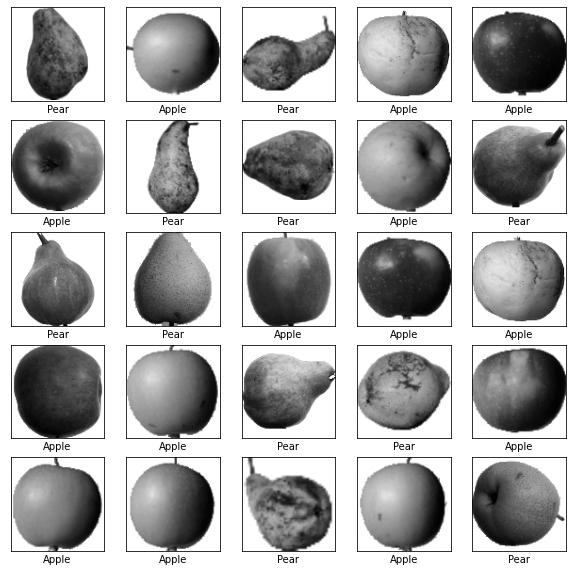

In [ ]:
import random
img_idx = random.sample(range(len(train_images)), 25)
img_idx = np.array(img_idx)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[img_idx[i]][0], cmap='gray')
    plt.xlabel(class_name[train_images[img_idx[i]][1]])
plt.show()

In [ ]:
# Read testing set
test_images = []
test_dir = os.path.join(base_dir, 'Test/')											                # set the test directory in the path

for category in CATEGORIES:															                        # iterate to each category
    path = os.path.join(test_dir, category)
    class_num = CATEGORIES.index(category)
    if class_num <= 12:
      class_num = 0
    else:
      class_num = 1
    for image in os.listdir(path):													                    # iterate to each image in the category
        if(image.endswith('jpg') and not image.startswith('.')):													
            img_array = cv2.imread(os.path.join(path,image),                    # read the image
                                   cv2.IMREAD_GRAYSCALE)	
            test_images.append([img_array, class_num])								          # save the image in test data array
            
print("Testing images: ", len(test_images))

Testing images:  3823


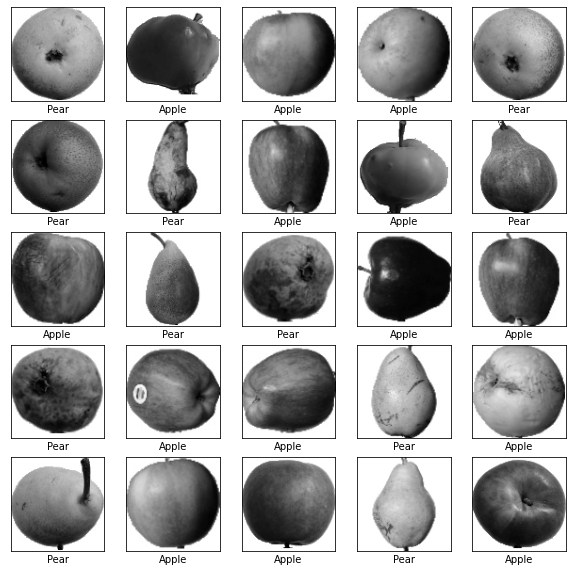

In [ ]:
import random
img_idx = random.sample(range(len(test_images)), 25)
img_idx = np.array(img_idx)

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[img_idx[i]][0], cmap='gray')
    plt.xlabel(class_name[test_images[img_idx[i]][1]])
plt.show()

In [ ]:
# Shuffle the dataset before training for better accuracy
x_train = []																		                                # array for images
y_train = []																		                                # array for labels

random.shuffle(train_images)														                        # shuffle training images

for features, label in train_images: 												                    # iterate to each image and the corresponding label in training data
	x_train.append(features)
	y_train.append(label)
x_train = np.array(x_train)
 
x_test = []																			                                # array for images
y_test = []																			                                # array for labels

random.shuffle(test_images) 														                        # shuffle testing images

for features, label in test_images: 												                    # iterate to each image and the corresponding label in training data
	x_test.append(features)
	y_test.append(label)
x_test = np.array(x_test)

In [ ]:
print(x_train.shape)
print(x_test.shape)

(11441, 100, 100)
(3823, 100, 100)


In [ ]:
# reshape and normalize the data before training
x_train = x_train.reshape(-1, img_size, img_size, 1)
mean_train = np.mean(x_train, axis=0)
x_train = x_train-mean_train
X_train = x_train/255

x_test = x_test.reshape(-1, img_size, img_size, 1)
mean_test = np.mean(x_test, axis=0)
x_test = x_test-mean_test
X_test = x_test/255

y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

print(x_train.shape)
print(x_test.shape)

(11441, 100, 100, 1)
(3823, 100, 100, 1)


In [ ]:
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')


X_train_mean = np.mean(X_train)
X_train -= X_train_mean
X_test_mean = np.mean(X_test)
X_test -= X_test_mean

y_train = np_utils.to_categorical(y_train,)
y_test = np_utils.to_categorical(y_test,)
y_train = np.delete(y_train,1,1)
y_test = np.delete(y_test,1,1)
print(y_train.shape, y_test.shape)



(11441, 1) (3823, 1)


In [ ]:
from tensorflow.keras.layers import Dropout
def vgg16(input_shape=(100, 100, 1), num_classes=2):
  model = Sequential()
  model.add(Conv2D(input_shape=input_shape,filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))


  model.add(Dropout(0.8))

  model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=16, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  # model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
  # model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

  model.add(Flatten())
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=4096,activation="relu"))
  model.add(Dense(units=1, activation="sigmoid"))

  return model

In [ ]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 180:
        lr *= 0.5e-3
    elif epoch > 160:
        lr *= 1e-3
    elif epoch > 120:
        lr *= 1e-2
    elif epoch > 80:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr


In [ ]:
# Prepare callbacks for model saving and for learning rate adjustment.

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler,early_stopping]


In [ ]:
 model = vgg16(input_shape,num_classes)

# Compile model

# optimizer = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss= 'binary_crossentropy' , optimizer=optimizer, metrics=['accuracy'])
print("Model Summary of ",model_type)
print(model.summary())



Model Summary of  vgg16
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 50, 50, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 16)        9232      
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 16)        2320      
                                

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Score trained model.
history = model.fit(X_train, y_train,
      batch_size=batch_size,
      epochs=epochs,
      validation_data=(X_test, y_test),
      shuffle=True,
      callbacks=callbacks)
scores = model.evaluate(X_test, y_test, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Learning rate:  0.001
Epoch 1/200
358/358 [==============================] - ETA: 0s - loss: 0.2583 - accuracy: 0.8780

358/358 [==============================] - 28s 50ms/step - loss: 0.2583 - accuracy: 0.8780 - val_loss: 0.3081 - val_accuracy: 0.8849 - lr: 0.0010
Learning rate:  0.001
Epoch 2/200
357/358 [============================>.] - ETA: 0s - loss: 0.0469 - accuracy: 0.9837

358/358 [==============================] - 16s 46ms/step - loss: 0.0468 - accuracy: 0.9837 - val_loss: 0.5696 - val_accuracy: 0.8585 - lr: 0.0010
Learning rate:  0.001
Epoch 3/200
357/358 [============================>.] - ETA: 0s - loss: 0.0258 - accuracy: 0.9922

358/358 [==============================] - 17s 46ms/step - loss: 0.0257 - accuracy: 0.9922 - val_loss: 0.2292 - val_accuracy: 0.9377 - lr: 0.0010
Learning rate:  0.001
Epoch 4/200
357/358 [============================>.] - ETA: 0s - loss: 0.0246 - accuracy: 0.9932

358/358 [==============================] - 17s 48ms/step - loss: 0.0254 - accuracy: 0.9931 - val_loss: 0.5193 - val_accuracy: 0.9087 - lr: 0.0010
Learning rate:  0.001
Epoch 5/200
357/358 [============================>.] - ETA: 0s - loss: 0.0220 - accuracy: 0.9941

358/358 [==============================] - 17s 46ms/step - loss: 0.0219 - accuracy: 0.9941 - val_loss: 0.5404 - val_accuracy: 0.9226 - lr: 0.0010
Learning rate:  0.001
Epoch 6/200
357/358 [============================>.] - ETA: 0s - loss: 0.0171 - accuracy: 0.9947

358/358 [==============================] - 17s 46ms/step - loss: 0.0171 - accuracy: 0.9947 - val_loss: 0.3251 - val_accuracy: 0.9325 - lr: 0.0010
Learning rate:  0.001
Epoch 7/200
357/358 [============================>.] - ETA: 0s - loss: 0.0012 - accuracy: 0.9996

358/358 [==============================] - 17s 46ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.3917 - val_accuracy: 0.9422 - lr: 0.0010
Learning rate:  0.001
Epoch 8/200
357/358 [============================>.] - ETA: 0s - loss: 0.0157 - accuracy: 0.9955

120/120 [==============================] - 2s 16ms/step - loss: 0.2292 - accuracy: 0.9377
Test loss: 0.22920112311840057
Test accuracy: 0.937745213508606


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


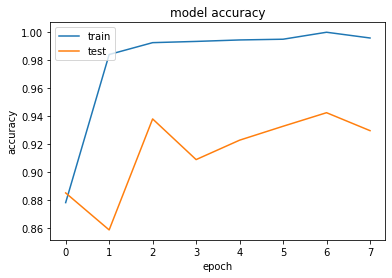

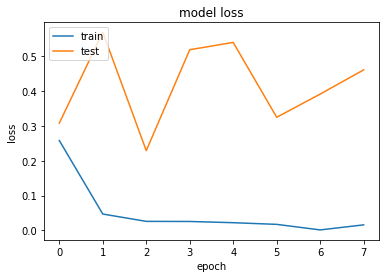

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

120/120 [==============================] - 2s 14ms/step


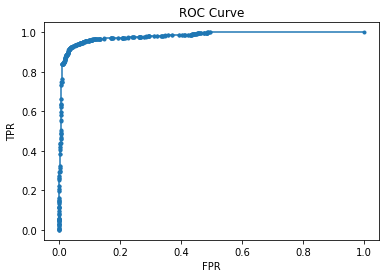

0.9806304979072371


In [ ]:
from sklearn.metrics import roc_curve, auc

y_pred = model.predict(X_test).ravel()

nn_fpr_keras, nn_tpr_keras, nn_thresholds_keras = roc_curve(y_test, y_pred)
auc_keras = auc(nn_fpr_keras, nn_tpr_keras)
plt.plot(nn_fpr_keras, nn_tpr_keras, marker='.', label='Neural Network (auc = %0.3f)' % auc_keras)
plt.title('ROC Curve')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

print(auc_keras)

120/120 [==============================] - 2s 14ms/step


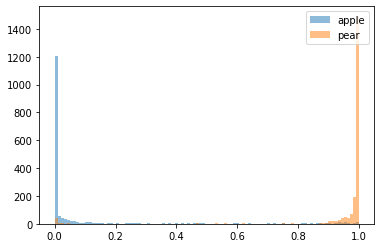

In [ ]:
from matplotlib import pyplot
predict_x=model.predict(X_test) 

apple_index = np.where(y_test.reshape(-1) == 0.)
apple = predict_x[apple_index]

pear_index = np.where(y_test.reshape(-1) == 1.)
pear = predict_x[pear_index]



bins = np.linspace(0, 1, 100)

pyplot.hist(apple, bins, alpha=0.5, label='apple')
pyplot.hist(pear, bins, alpha=0.5, label='pear')
pyplot.legend(loc='upper right')
pyplot.show()

In [ ]:
for X,Y in zip(predict_x,y_test):
    print("Model Score:", X, "actual score:", Y) 

Model Score: [0.99967897] actual score: [1.]
Model Score: [0.99491525] actual score: [1.]
Model Score: [0.8857441] actual score: [1.]
Model Score: [0.9954347] actual score: [1.]
Model Score: [0.902415] actual score: [0.]
Model Score: [0.98691314] actual score: [1.]
Model Score: [0.06032395] actual score: [0.]
Model Score: [0.9999778] actual score: [1.]
Model Score: [0.1195865] actual score: [0.]
Model Score: [0.04235536] actual score: [0.]
Model Score: [0.9999188] actual score: [1.]
Model Score: [0.01310002] actual score: [0.]
Model Score: [0.9849997] actual score: [1.]
Model Score: [0.95503837] actual score: [1.]
Model Score: [0.00306625] actual score: [0.]
Model Score: [0.9986934] actual score: [1.]
Model Score: [0.99995804] actual score: [1.]
Model Score: [0.99991524] actual score: [1.]
Model Score: [0.9985252] actual score: [1.]
Model Score: [1.0200089e-05] actual score: [0.]
Model Score: [0.9996302] actual score: [1.]
Model Score: [0.99155855] actual score: [1.]
Model Score: [2.05